In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib.font_manager as fm
from shapely.geometry import Polygon, Point
from geopy.distance import great_circle
from geopy.point import Point
import geopy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
#from geopandas import GeoDataFrame
#from descartes import PolygonPatch
import geopy
import datetime
import os
import warnings
import notebook
import pickle
import seaborn as sns
warnings.filterwarnings('ignore')
E = notebook.nbextensions.EnableNBExtensionApp()
E.enable_nbextension('usability/codefolding/main')
E.enable_nbextension('usability/hide_input/main')
E.enable_nbextension('usability/hide_input_all/main')
E.enable_nbextension('usability/highlighter/highlighter')
E.enable_nbextension('usability/toggle_all_line_numbers/main')
E.enable_nbextension('usability/rubberband/main')
E.enable_nbextension('usability/execute_time/ExecuteTime')
E.enable_nbextension('usability/autoscroll.js')
from lightning import Lightning
#lgn = Lightning(ipython=True, local=True)
import codecs, json ,base64
import simplejson
import IPython.core.display as di
from ggplot import *
from shapely.geometry import Polygon, Point
from itertools import product
import itertools
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
import fiona
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
import json
import datetime
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)
from IPython.core.display import HTML
def ldf_display(df, lines=15):
    txt = ("<iframe " +
           "srcdoc='" + df.head(lines).to_html() + "' " +
           "width=1900 height=200>" +
           "</iframe>")

    return HTML(txt)
import matplotlib as mpl
mpl.style.use('ggplot')
theme_bw()
mpl.rcParams['figure.figsize'] = "25.0, 13.0"
mpl.rcParams.update({'font.size': 22})
%matplotlib inline

/home/ecoker/.local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Toggle code

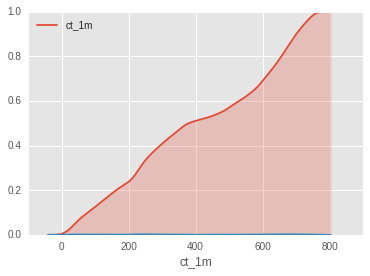

In [2]:
## Use distance data for Liquor establishments to Accident to calculate nbr of Places allowed to sell alcohol within 1 mile of accident of accident ID. Perhaps this metric could be interesting...
dist_to_liq = pickle.load( open( "distance_data.p", "rb" ) )
dist_to_liq.drop_duplicates()
dist_to_liq['ct_1m'] = dist_to_liq.groupby('id')['biz_name'].transform(lambda x: x.nunique())
del dist_to_liq['biz_name']
dist_to_liq['id'] = dist_to_liq['id'].str.replace('id ', '')
p=sns.kdeplot(dist_to_liq['ct_1m'], shade=True,cumulative=True);
q=sns.distplot(dist_to_liq['ct_1m'], hist=False);

# X = np.sort(dist_to_liq['ct_1m'].values)
# #a = array([...]) # your array of numbers
# num_bins = 20
# counts, bin_edges = np.histogram(X, bins=num_bins, normed=True)
# cdf = np.cumsum(counts)
# plt.plot(bin_edges[1:], cdf)

This above plot of the 'ct_1m' metric (liq within 1mi), is a CDF plot and shows that 80% (.8 on the y axis) of all Accidents have @650 establishments allowed to sell liquor, within 1 mile. 

In [3]:
frames = pickle.load( open( "accident_info_2012-13-14.p", "rb" ) )
traffic = pickle.load( open( "traffic2.p", "rb" ) )
del traffic['lat'], traffic['lon']
dist_to_liq = pickle.load(open("distance_data.p","rb"))
segments = pd.read_csv('Segments.csv')
segments.columns=['segment_id','STREET','direction','FROM_STREET','TO_STREET','length','STREET_HEADING','COMMENTS','START_LONGITUDE','START_LATITUDE','END_LONGITUDE','END_LATITUDE','CURRENT_SPEED','datetime']
keepcols = ['segment_id','START_LATITUDE','END_LATITUDE','START_LONGITUDE','END_LONGITUDE']
segments = segments.loc[:,keepcols]
segments['longitude']=((segments['START_LONGITUDE']+segments['END_LONGITUDE']) / 2)
segments['latitude']=((segments['START_LATITUDE']+segments['END_LATITUDE']) / 2)
traffic = pd.merge(segments,traffic,on='segment_id',how='inner')
pickle.dump(traffic, open( "traffcoords.p", "wb" ))
ldf_display(traffic)

,segment_id,START_LATITUDE_x,END_LATITUDE_x,START_LONGITUDE_x,END_LONGITUDE_x,longitude,latitude,daytetime,speed,direction,length,START_LATITUDE_y,END_LATITUDE_y,START_LONGITUDE_y,END_LONGITUDE_y,dayte,hour,dow,avg_day_spd,avg_dly_spd,avg_h_spd,datetime_recorded
0,1299,41.886928,41.878134,-87.632584,-87.632357,-87.63247,41.882531,2014-12-30 11:00:00,17,SB,0.6,41.886928,41.878134,-87.632584,-87.632357,2014-12-30,11,1,7.636997,8.4375,5.357124,2014-12-30 11:50:32
1,1299,41.886928,41.878134,-87.632584,-87.632357,-87.63247,41.882531,2014-12-30 11:00:00,-1,SB,0.6,41.886928,41.878134,-87.632584,-87.632357,2014-12-30,11,1,7.636997,8.4375,5.357124,2014-12-30 11:50:32
2,1299,41.886928,41.878134,-87.632584,-87.632357,-87.63247,41.882531,2014-12-30 11:00:00,-1,SB,0.6,41.886928,41.878134,-87.632584,-87.632357,2014-12-30,11,1,7.636997,8.4375,5.357124,2014-12-30 11:50:32
3,1299,41.886928,41.878134,-87.632584,-87.632357,-87.63247,41.882531,2014-12-30 11:00:00,14,SB,0.6,41.886928,41.878134,-87.632584,-87.632357,2014-12-30,11,1,7.636997,8.4375,5.357124,2014-12-30 11:50:32
4,1299,41.886928,41.878134,-87.632584,-87.632357,-87.63247,41.882531,2014-12-30 11:00:00,-1,SB,0.6,41.886928,41.878134,-87.632584,-87.632357,2014-12-30,11,1,7.636997,8.4375,5.357124,2014-12-30 11:50:32
5,1299,41.886928,41.878134,-87.632584,-87.632357,-87.63247,41.882531,2014-12-30 11:00:00,20,SB,0.6,41.886928,41.878134,-87.632584,-87.632357,2014-12-30,11,1,7.636997,8.4375,5.357124,2014-12-30 11:50:32
6,1299,41.886928,41.878134,-87.632584,-87.632357,-87.63247,41.882531,2014-12-30 11:00:00,-1,SB,0.6,41.886928,41.878134,-87.632584,-87.632357,2014-12-30,11,1,7.636997,8.4375,5.357124,2014-12-30 11:50:32
7,1299,41.886928,41.878134,-87.632584,-87.632357,-87.63247,41.882531,2014-12-30 11:00:00,18,SB,0.6,41.886928,41.878134,-87.632584,-87.632357,2014-12-30,11,1,7.636997,8.4375,5.357124,2014-12-30 11:50:32
8,1299,41.886928,41.878134,-87.632584,-87.632357,-87.63247,41.882531,2014-12-30 11:00:00,-1,SB,0.6,41.886928,41.878134,-87.632584,-87.632357,2014-12-30,11,1,7.636997,8.4375,5.357124,2014-12-30 11:50:32
9,1299,41.886928,41.878134,-87.632584,-87.632357,-87.63247,41.882531,2014-12-30 11:00:00,25,SB,0.6,41.886928,41.878134,-87.632584,-87.632357,2014-12-30,11,1,7.636997,8.4375,5.357124,2014-12-30 11:50:32


In [4]:
frames.loc[frames['accident_type']==1,"accident_type_c"] = 'walker'
frames.loc[frames['accident_type']==2,"accident_type_c"] = 'biker'
frames.loc[frames['road_surface']==1,"road_surface_c"] = 'dry'
frames.loc[frames['road_surface']==2,"road_surface_c"] = 'wet'
frames.loc[frames['road_surface']==3,"road_surface_c"] = 'snow'
frames.loc[frames['road_surface']==4,"road_surface_c"] = 'ice'
frames.loc[frames['road_surface']==5,"road_surface_c"] = 'sand_mud'
frames.loc[frames['road_surface']==6,"road_surface_c"] = 'other'
frames.loc[frames['road_surface']==9,"road_surface_c"] = 'unknown'
frames.loc[frames['lighting']==1,"lighting_c"] = 'daylight'
frames.loc[frames['lighting']==2,"lighting_c"] = 'dawn'
frames.loc[frames['lighting']==3,"lighting_c"] = 'dusk'
frames.loc[frames['lighting']==4,"lighting_c"] = 'darkness'
frames.loc[frames['lighting']==5,"lighting_c"] = 'darkness_lighted_road'
frames.loc[frames['lighting']==9,"lighting_c"] = 'unknown'
frames.loc[frames['weather']==1,"weather_c"] = 'clear'
frames.loc[frames['weather']==2,"weather_c"] = 'rain'
frames.loc[frames['weather']==3,"weather_c"] = 'snow'
frames.loc[frames['weather']==4,"weather_c"] = 'fog_haze'
frames.loc[frames['weather']==5,"weather_c"] = 'sleet_hail'
frames.loc[frames['weather']==6,"weather_c"] = 'severe_wind'
frames.loc[frames['weather']==7,"weather_c"] = 'other'
frames.loc[frames['weather']==8,"weather_c"] = 'cloudy'
frames.loc[frames['weather']==9,"weather_c"] = 'unknown'
frames.loc[frames['intersection']=='Y',"intersection_c"] = 'yes'
frames.loc[frames['intersection']=='N',"intersection_c"] = 'no'
frames.loc[frames['hit_run']=='Y',"hit_run_c"] = 'yes'
frames.loc[frames['hit_run']=='N',"hit_run_c"] = 'no'
frames.loc[frames['trafficway']==1,"trafficway_c"] = '2way_no_divide'
frames.loc[frames['trafficway']==2,"trafficway_c"] = '2way_no_lo_barrier'
frames.loc[frames['trafficway']==3,"trafficway_c"] = '2way_with_barrier'
frames.loc[frames['trafficway']==4,"trafficway_c"] = '2way_center_turnln'
frames.loc[frames['trafficway']==5,"trafficway_c"] = 'one_way_or_ramp'
frames.loc[frames['trafficway']==6,"trafficway_c"] = 'alley_or_drive'
frames.loc[frames['trafficway']==7,"trafficway_c"] = 'parkinglot'
frames.loc[frames['trafficway']==8,"trafficway_c"] = 'other'
frames.loc[frames['trafficway']==9,"trafficway_c"] = 'unknown'
frames.loc[frames['trafficway']==10,"trafficway_c"] = 'one_way_or_ramp'
frames.loc[frames['trafficway']==11,"trafficway_c"] = 'one_way_or_ramp'
frames.loc[frames['trafficway']==12,"trafficway_c"] = 'alley_or_drive'
frames.loc[frames['trafficway']==13,"trafficway_c"] = 'alley_or_drive'
frames.loc[frames['roadway']==10,"roadway_c"] = 'interstate'
frames.loc[frames['roadway']==20,"roadway_c"] = 'freeway'
frames.loc[frames['roadway']==30,"roadway_c"] = 'other_maj_arterial'
frames.loc[frames['roadway']==40,"roadway_c"] = 'minor_arterial_non_urb'
frames.loc[frames['roadway']==50,"roadway_c"] = 'major_collector_non_urb'
frames.loc[frames['roadway']==60,"roadway_c"] = 'local_non_urb'
frames.loc[frames['roadway']==70,"roadway_c"] = 'minor_arterial_urban'
frames.loc[frames['roadway']==80,"roadway_c"] = 'collector_urban'
frames.loc[frames['roadway']==90,"roadway_c"] = 'local_urban'

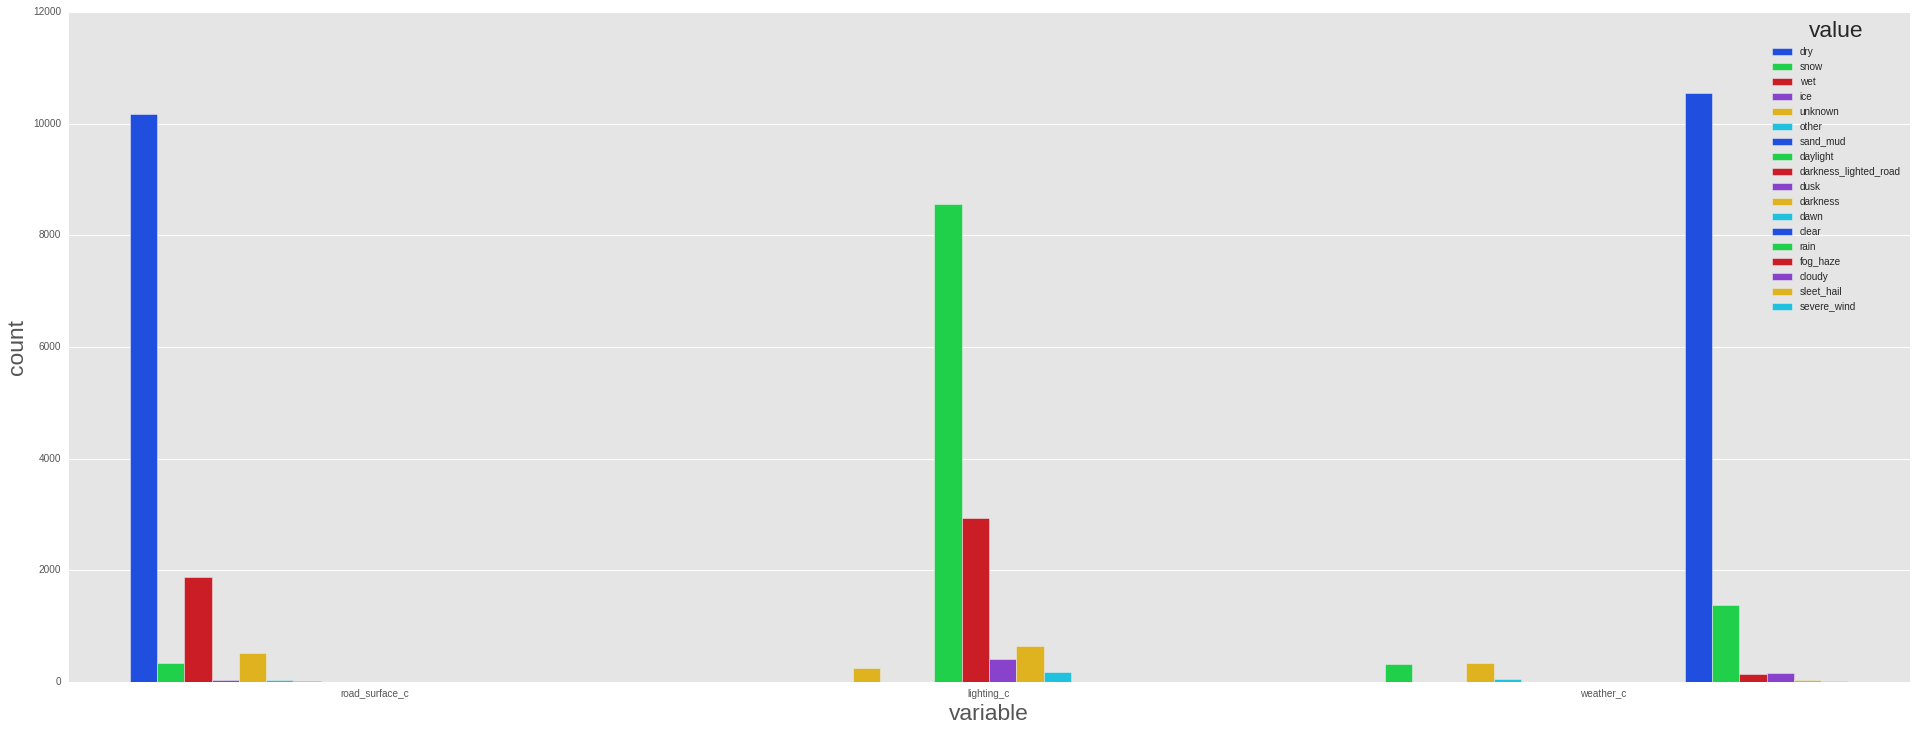

In [5]:
## Plot the Categoricals, do any of these accident characteristics look interesting?

mpl.rcParams['figure.figsize'] = "33.0, 12.0"
mpl.rcParams.update({'font.size': 19})
mpl.rcParams.update({'axes.labelsize' : 'large'})
barpltcols = ['id','road_surface_c','lighting_c','weather_c']
barpltcols2 = ['id','intersection_c','trafficway_c','roadway_c']
plt_cat = pd.melt((frames.loc[:,barpltcols]),id_vars='id')
plt_cat2 = pd.melt((frames.loc[:,barpltcols2]),id_vars='id')

plot = sns.countplot(x="variable", data=plt_cat,palette="bright",hue='value')
# # We change the fontsize of minor ticks label 
plot.tick_params(axis='both', which='major', labelsize=10)
plot.tick_params(axis='both', which='minor', labelsize=8)

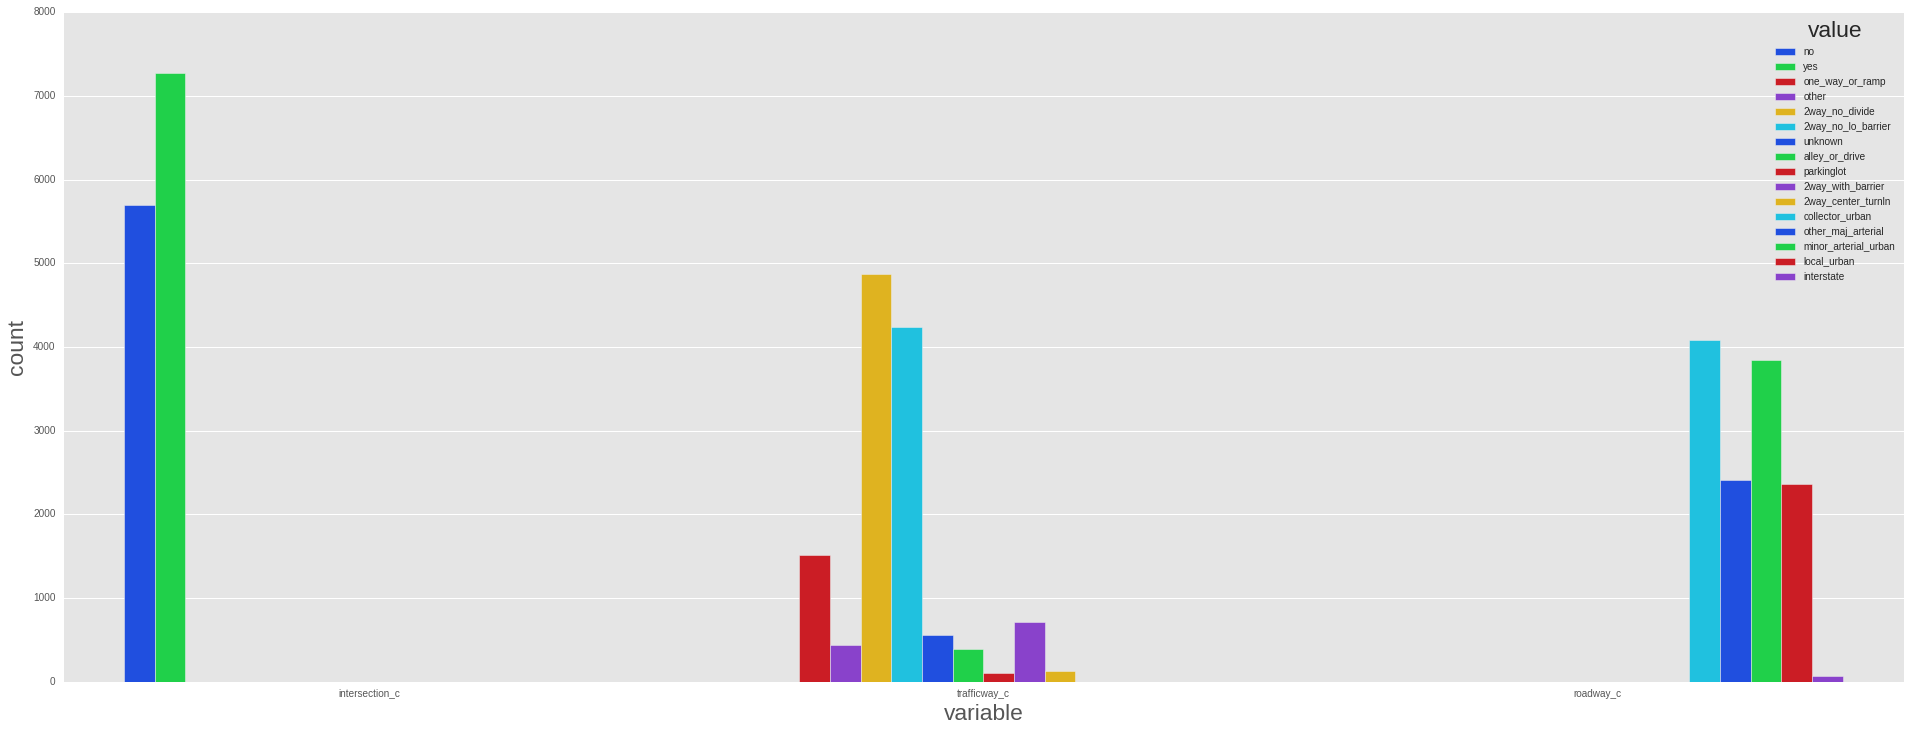

In [23]:
qq = sns.countplot(x="variable", data=plt_cat2,palette="bright",hue='value');

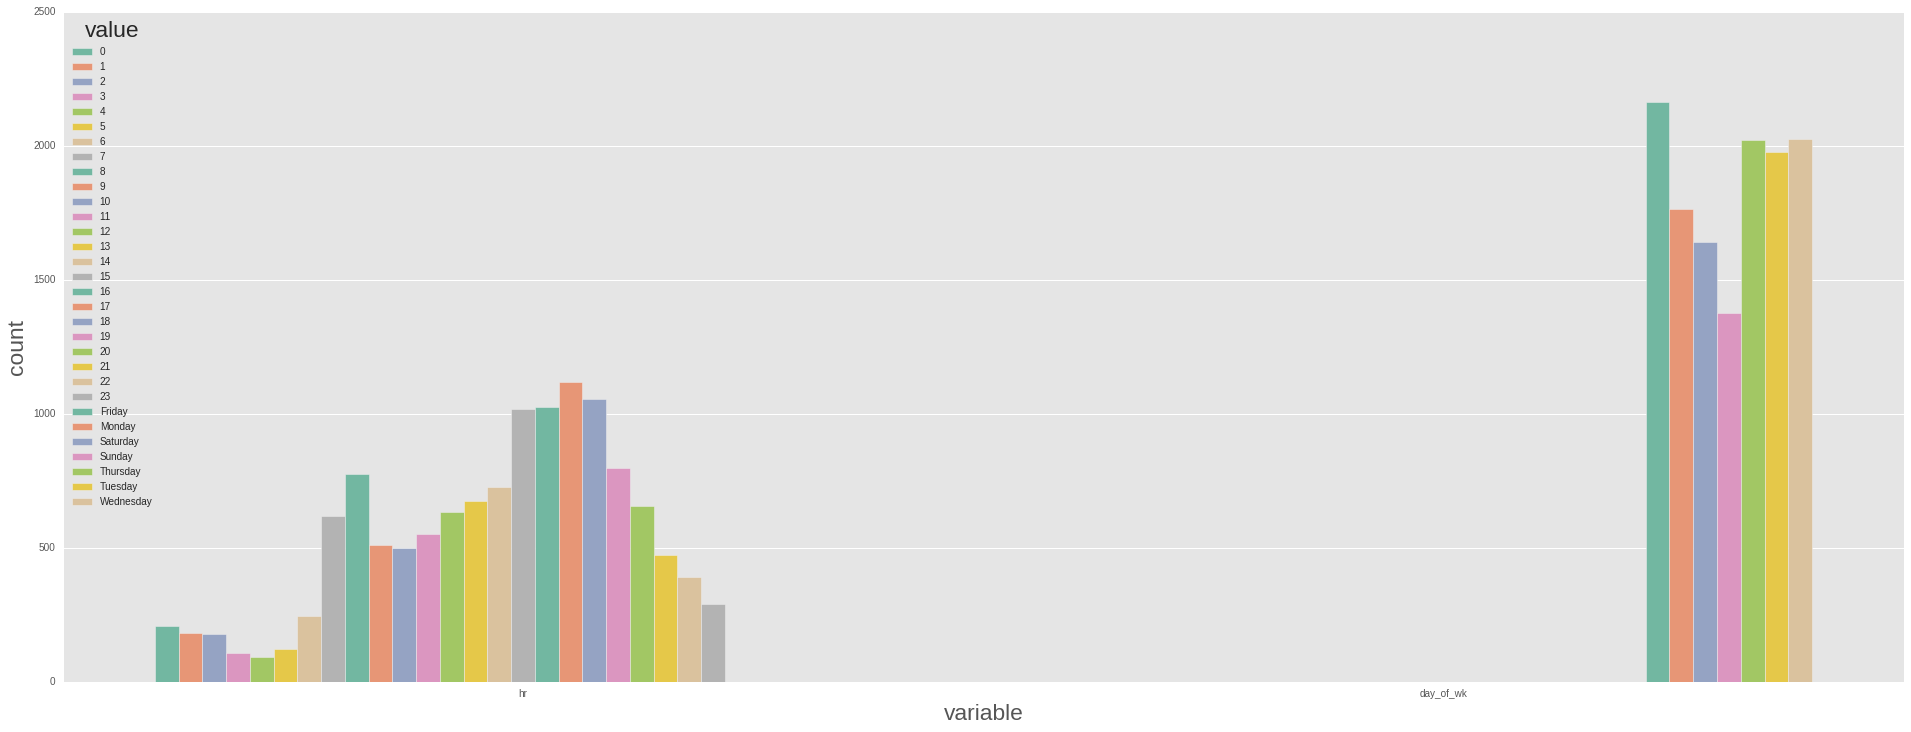

In [24]:
## Specifically, does day of week or time have significance as it relates to accidents?
frames = frames.sort_values(by=['datetime_accident','day_of_wk'])
frames['hr'] = frames['datetime_accident'].dt.hour.astype('int64')
timecols = ['id','day_of_wk','hr']
timecols2 = ['id','day_of_wk','hr','accident_type_c']
plt_cat2 = pd.melt((frames.loc[:,timecols]),id_vars=['id'])
plt_cat3 = pd.melt((frames.loc[:,timecols2]),id_vars=['id','accident_type_c'])
plt_cat2 = plt_cat2.sort_values(by='value')
h = sns.countplot(x="variable", data=plt_cat2,palette="Set2",hue='value')
h.tick_params(axis='both',which='major',labelsize=10)
h.tick_params(axis='both',which='minor',labelsize=10)

In [22]:
# 3 variables seemed most dominant and it would be interesting to see if they're independent of each other...
    ## Are day of the week and roadway independent of each other? Are lighting and day of the week indepdendent? 
chisq_cols = ['day_of_wk','roadway_c','lighting_c']

chisq = frames.loc[:,chisq_cols]
import scipy.stats as scs
def chi_square_of_df_cols(df, col1, col2):
    df_col1, df_col2 = df[col1], df[col2]
    cats1, cats2 = categories(df_col1), categories(df_col2)

    def aux(is_cat1):
        return [sum(is_cat1 & (df_col2 == cat2))
                for cat2 in cats2]

    result = [aux(df_col1 == cat1)
              for cat1 in cats1]

    return scs.chi2_contingency(result)

from scipy.stats import chi2_contingency

def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(chi2_contingency(ctsum.fillna(0)))

p = chisq_of_df_cols(chisq, 'day_of_wk', 'roadway_c')
q = chisq_of_df_cols(chisq, 'day_of_wk', 'lighting_c')
print "Day of Wk vs Roadway is:",p
print "Day of Wk vs Lighting is:",q, """
So there is no relationship such as Friday nights or Monday mornings"""

Day of Wk vs Roadway is: (27.397343785503146, 0.28627531059869288, 24, array([[ 680.34695475,  556.61844371,  515.3756067 ,  431.2913731 ,
         639.10411774,  623.43823391,  637.82527008],
       [  10.66165649,    8.72271802,    8.0764052 ,    6.75872867,
          10.01534367,    9.769845  ,    9.99530296],
       [ 394.48129012,  322.74056678,  298.82699233,  250.0729607 ,
         370.56771567,  361.48426491,  369.82620949],
       [ 641.03209645,  524.45342101,  485.59386253,  406.36856114,
         602.17253797,  587.41193048,  600.96759042],
       [ 401.47800219,  328.46485048,  304.12713324,  254.50837639,
         377.14028495,  367.89572569,  376.38562705]]))
Day of Wk vs Lighting is: (204.22506933027668, 7.9995721529375236e-28, 30, array([[  106.37431589,    86.75186927,    80.8012025 ,    67.67039235,
           99.53842596,    97.22700994,    99.63678409],
       [  490.85577738,   400.30956602,   372.85068989,   312.25961613,
          459.31210977,   448.64626532,  

In [ ]:
%reload_ext Cython

In [3]:
%%cython -a
import numpy as np
import pandas as pd
import pickle 

framescoords = pickle.load(open( "framecoords.p", "rb" )) 
del framescoords['dist_sums']
traffic = pickle.load(open( "traffcoords.p", "rb" ))
framescoords['lat_acc'] = framescoords['latitude']
framescoords['lon_acc'] = framescoords['longitude']
traffic['lat_traff'] = traffic['latitude']
traffic['lon_traff'] = traffic['longitude']
del framescoords['latitude']
del framescoords['longitude']
del traffic['latitude']
del traffic['longitude']
trafficcols = ['segment_id','lat_traff','lon_traff']
traffic = traffic.loc[:,trafficcols].drop_duplicates().dropna()
def expand_grid(x, y):
    xG, yG = np.meshgrid(x, y) # create the actual grid
    xG = xG.flatten() # make the grid 1d
    yG = yG.flatten() # same
    return pd.DataFrame({'x':xG, 'y':yG})

keepseg = ['segment_id']
traff = traffic.segment_id.drop_duplicates()
framescoord = framescoords['id'].drop_duplicates()

traffx = traff.as_matrix()
framex = framescoord.as_matrix()

distances2 = expand_grid(framex, traffx)
pickle.dump(distances2, open("dist2.p", "wb"))

distances2 = pickle.load(open("dist2.p", "rb" )) 
distances2.columns = ['id','segment_id']
distances2 = distances2.drop_duplicates().dropna()
distances_spd1 = pd.merge(distances2,traffic,how='left',on='segment_id')
distances_spds = pd.merge(distances_spd1,framescoords,how='left',on='id').dropna()
pickle.dump(distances_spds, open("dist_spds.p", "wb"))
print distances_spds.head()
# pickle.dump(distances_spd1, open("distances_spd1.p", "wb"))
# distances_spd1.head()

ERROR: Cell magic `%%cython` not found.


In [ ]:
%%cython -a
import numpy as np
import pandas as pd
import pickle 
from geopy.distance import great_circle
import geopy
distances_spds = pickle.load(open("dist_spds.p", "rb")).drop_duplicates().dropna()
distances_spds['distances'] = distances_spds.apply(lambda x: great_circle((x['lat_traff'],x['lon_traff']), (x['lat_acc'], x['lon_acc'])).miles, axis=1)
pickle.dump(distances_spds, open("traffic_spds.p", "wb"))

In [8]:
## Merge in the metrics (traffic spds as it turns out only seem to be relevant for 1 hour in the day?), and Number of Liquor Establishments
distances_spds = pickle.load(open("traffic_spds.p", "rb"))
del distances_spds['lat_traff']
del distances_spds['lon_traff']
del distances_spds['lat_acc']
del distances_spds['lon_acc']
distances_spds = distances_spds.sort_values(by=['id','distances'],ascending=True)
distances_spds = distances_spds.drop_duplicates(subset=['id'])
ldf_display(distances_spds)

,id,segment_id,distances
9075886,6804820,589,0.290413
876908,6805622,1242,0.276311
8884470,6805776,233,0.008951
10404218,6805778,364,0.551175
13303224,6805786,132,0.119887
8552293,6805805,219,0.228189
2039072,6812925,950,0.461355
11655636,6812929,82,0.146866
1464379,6812931,1222,0.056756
10365771,6812944,337,0.009289


In [9]:
#del distances_spds['distances']
distances_spds['segment_id'] = distances_spds['segment_id'].astype('float64')
frames['id'] = frames['id'].astype('float64')
traffic['segment_id'] = traffic['segment_id'].astype('float64')
newtraffic = pd.merge(distances_spds,traffic, how='right',on='segment_id')
newframes = pd.merge(frames,newtraffic,how='left',on=['daytetime','id'])
dist_to_liq['id'] = dist_to_liq['id'].str.replace('id ', '')
dist_to_liq['id'] = dist_to_liq['id'].astype('float64')
lastframe = pd.merge(newframes,dist_to_liq,how='left',on='id')
keepfinal = ['id','daytetime','datetime_accident','accident_type','road_surface','lighting','weather','intersection','hit_run','trafficway','roadway','latitude_x','longitude_x','day_of_wk',
 'cause1','cause2','crash_severity','accident_type_c','road_surface_c','lighting_c','weather_c','intersection_c','hit_run_c','trafficway_c','roadway_c','hr','segment_id',
 'dayte','hour','dow','avg_day_spd','avg_dly_spd','avg_h_spd','datetime_recorded','biz_name','distances','ct_1m']
modelcols = ['id','daytetime','datetime_accident','accident_type','road_surface','lighting','weather','intersection','hit_run','trafficway','roadway','latitude_x','longitude_x'
             ,'crash_severity','hr','segment_id', 'dayte','hour','day_of_wk','avg_day_spd','avg_dly_spd','avg_h_spd','ct_1m']
lastframe = lastframe.loc[:,keepfinal]
modelframe = lastframe.loc[:,modelcols].drop_duplicates()
ldf_display(modelframe)

,id,daytetime,datetime_accident,accident_type,road_surface,lighting,weather,intersection,hit_run,trafficway,roadway,latitude_x,longitude_x,crash_severity,hr,segment_id,dayte,hour,day_of_wk,avg_day_spd,avg_dly_spd,avg_h_spd,ct_1m
0,7753890,2014-01-27 11:00:00,2014-01-27 11:45:00,1,1,1,1,N,Y,3,70,41.851547,-87.732109,C Injury Crash,NaN,NaN,NaT,NaN,Monday,NaN,NaN,NaN,26
26,7736171,2014-01-09 22:00:00,2014-01-09 22:15:00,1,3,5,3,N,Y,2,90,41.776769,-87.606039,B Injury Crash,NaN,NaN,NaT,NaN,Thursday,NaN,NaN,NaN,11
37,7736175,2014-01-10 19:00:00,2014-01-10 19:45:00,1,2,5,2,N,Y,1,80,41.743127,-87.659930,B Injury Crash,NaN,NaN,NaT,NaN,Friday,NaN,NaN,NaN,12
49,7763023,2014-02-04 09:00:00,2014-02-04 09:00:00,1,1,1,9,Y,Y,10,70,41.881870,-87.639694,No Injuries,NaN,NaN,NaT,NaN,Tuesday,NaN,NaN,NaN,608
691,7736186,2014-01-11 09:00:00,2014-01-11 09:35:00,1,2,1,2,Y,N,2,70,41.736810,-87.592404,B Injury Crash,NaN,NaN,NaT,NaN,Saturday,NaN,NaN,NaN,15
706,7762426,2014-02-02 18:00:00,2014-02-02 18:15:00,1,2,5,1,N,Y,1,90,41.781578,-87.763081,C Injury Crash,NaN,NaN,NaT,NaN,Sunday,NaN,NaN,NaN,24
730,7754214,2014-01-26 16:00:00,2014-01-26 16:52:00,1,3,5,3,N,Y,9,90,41.838720,-87.725999,B Injury Crash,NaN,NaN,NaT,NaN,Sunday,NaN,NaN,NaN,28
758,7754215,2014-01-27 06:00:00,2014-01-27 06:25:00,1,3,5,1,Y,Y,2,80,41.994510,-87.785160,B Injury Crash,NaN,NaN,NaT,NaN,Monday,NaN,NaN,NaN,28
786,7740814,2014-01-20 14:00:00,2014-01-20 14:25:00,2,1,1,1,N,Y,2,70,41.884480,-87.692491,B Injury Crash,NaN,NaN,NaT,NaN,Monday,NaN,NaN,NaN,35
821,7762437,2014-02-02 17:00:00,2014-02-02 17:10:00,1,3,3,1,Y,N,1,70,41.808611,-87.664970,B Injury Crash,NaN,NaN,NaT,NaN,Sunday,NaN,NaN,NaN,22


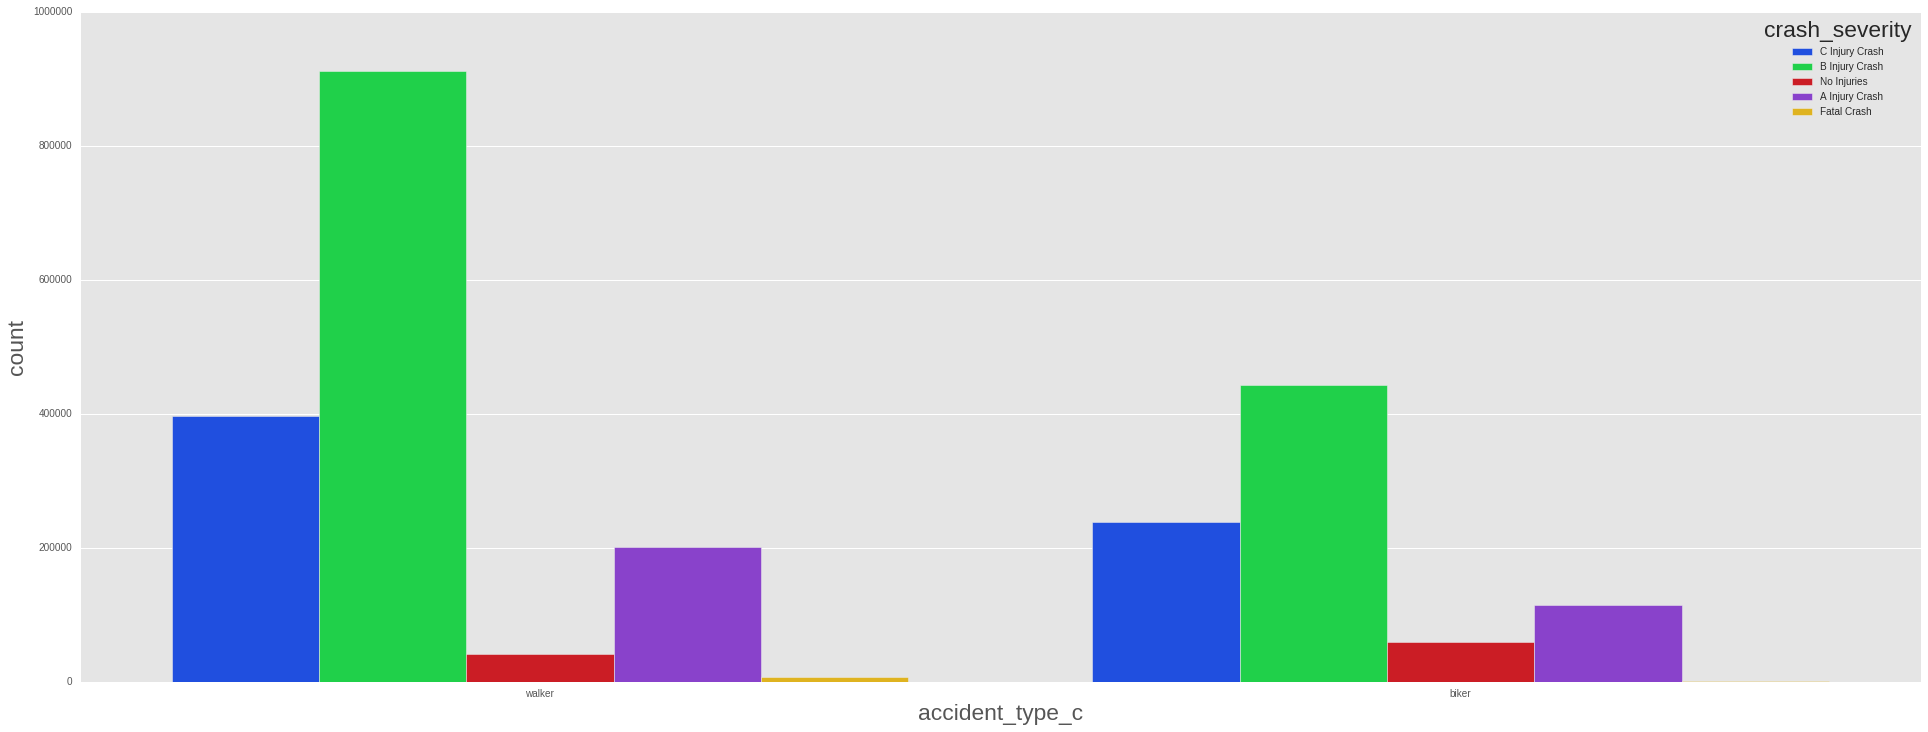

In [15]:
## Let's look at the severity of accidents, separately for pedestrian and pedalcyclist. Relative distributions between Pedestrian/Pedalcyclist look similar, so I don't think this makes 1 look more dangerous than the other.
    ## But in R, I'd like to try to model this.
col = ['accident_type_c','crash_severity','id']
differences = lastframe.loc[:,col]
differences['count'] = differences.groupby(['accident_type_c'])['crash_severity'].transform(lambda x: x.count())
differences['sum'] = differences.groupby(['accident_type_c'])['id'].transform(lambda x: x.sum())
differences['percentage'] = (differences['count'] / differences['sum']) * 100 
del differences['count'], differences['sum'], differences['id']
sns.countplot(x='accident_type_c',data=differences,palette="bright",hue='crash_severity')
#differences['count'] = differences.groupby(['accident_type_c'])['crash_severity'].transform(lambda x: x.count())

In [16]:
modelframe['hr'] = modelframe['datetime_accident'].dt.hour.astype('float64')
modelframe.to_csv('model_accidents.csv')
# temp = modelframe[modelframe.id == 	7736186]
# ldf_display(temp)

In [17]:
## Can we identify outliers in accident data and remove them.
from sklearn import neighbors
import pickle

framescoords = frames.loc[:,['latitude','longitude','id']].dropna()
coords=[]
coords = zip(framescoords["latitude"],framescoords["longitude"])
# # create our tree
tree = neighbors.KDTree(coords,leaf_size=2)
dist, ind = tree.query(coords[7], k=6) # look at row 7    
print(ind[0])  # indices of 5 closest neighbors
print(sum(dist[0][1:]))  # distances to 5 closest neighbors, excluding the point itself


# # to add the sum of distances, we'll loop through our list 
sums = []
for i in range(len(coords)):
    dist, ind = tree.query(coords[i], k=6)
    sums.append(sum(dist[0][1:]))


# # add the sums back to our dataframe
framescoords['dist_sums'] = pd.Series(sums, index=framescoords.index)

# #sort them so we can find the outlier-est outlier
outliers = framescoords.sort(['dist_sums'], ascending=False)
pickle.dump(framescoords, open( "framecoords.p", "wb" ))

[   7 1703 2366 7435  167 7830]
0.00683525642926


In [18]:
ldf_display(outliers)

,latitude,longitude,id,dist_sums
247823,41.994923,-87.884503,7672230,0.097694
166923,41.973290,-87.862271,7528272,0.092846
77811,41.976437,-87.878812,7393397,0.083404
126102,41.668246,-87.559270,7476261,0.081925
90231,41.981140,-87.878195,7910583,0.081458
163140,41.650818,-87.526363,8031796,0.077073
103407,41.687185,-87.739588,7925417,0.067247
77479,41.690920,-87.739751,7884319,0.064464
262574,41.666815,-87.544484,7700726,0.064125
45345,42.011990,-87.788700,7070625,0.061873


In [28]:
## TO DO ... 
    ## Would it help to see if any of the Accidents are plotted? Would it make sense to create polygons for these accidents based on clustering, and then count nbr of Liquor Establishments in Poly?
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

shapefilename = '/home/ecoker/b/Boundaries - Census Blocks - 2010/geo_export_b270ad12-45f9-49cd-85d2-c9fb9121c013'
shp = fiona.open(shapefilename+'.shp')
coords = shp.bounds
shp.close()
w,h = coords[2]-coords[0],coords[3]-coords[1]
extra = 0.01
m = Basemap(projection='tmerc', ellps='WGS84',
    lon_0=np.mean([coords[0], coords[2]]),
    lat_0=np.mean([coords[1], coords[3]]),
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - (extra * h), 
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + (extra * h),
    resolution='i',  suppress_ticks=True)
_out = m.readshapefile(shapefilename, name='chicago', drawbounds=False, color='none', zorder=2)